*Press button below to toggle code cells (There is a lot!)*

In [37]:
#https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
#cool code for a button to hide code 
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


## Researching text processing for product classification

So currently I am involved in a project in which we are creating a web scraping tool, that will grab product data from several websites, clean and aggregate them into a database ready for analysis. However, sometimes you can not code for every edge case in obtaining the information from these web pages, and a problem occurs in that a certain product trait may be missing. So my thoughts were to research into is there a way we can auto classify these traits, from simple attempts to more advanced. These products have descriptions, so we will concentrate on analysing the text for any insights. We will be looking at trying to classify the 'product_format', which is whether it's a can, container etc.

I've look at the following:

<ol>
<li>Simple word association between the description and what product format it takes on </li>
<li>Creating a classification system based on the frequencies of popular words within the description, correspondeing with the product format</li>
<li>Desceription pattern recognition (ML)</li>
</ol>

In [43]:
# load up libraries and create some helper functions

%matplotlib inline
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import sys
#!{sys.executable} -m pip install -U spacy
import spacy
from Abbott_lookup import ab_lookup 
#import en_core_web_sm
#nlp = en_core_web_sm.load()

nlp = spacy.load('en_core_web_sm')
#https://towardsdatascience.com/a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


def clean_text(txt):
    d = lemmatize_text(txt)
    d = d.encode('ascii',errors='ignore').decode('utf-8')
    d = d.replace('\n',' ')
    d = d.replace('\.',' ')
    d = re.sub('[^A-Za-z0-9 ]+', '', d)
    return d

def remove_stopwords(d):
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(d)
    words = [t.lower() for t in tokens if t not in stopwords]
    return words

### 1.) **Simple word association**

So first we are simply looking at how often a product_format name occurs in the description text, can we easily use this to fill in any missing product_format names.

See below what the data looks like

                                         description  \
0  Similac Pro-Sensitive is the first infant form...   
1  Due to high demand, to ensure availability for...   
2  Due to high demand, to ensure availability for...   
3  Similac Advance is designed to support your ba...   
4  Similac Pro-Sensitive is the first infant form...   

                                                name product_format  
0        Similac Pro-Sensitive Infant Formula Powder            can  
1          Similac Pro-Advance Infant Formula Powder            can  
2   Similac Pro-Advance Infant Formula Ready-to-Feed         bottle  
3              Similac Advance Infant Formula Powder            can  
4  Similac Pro-Sensitive Infant Formula Ready-to-...         bottle  

Number of porduct_format types 18
Types: cup, Tetra, lancet, strips, packet, ice pack, packets, log book, carrying case, container, carton, solution, bottle, oz, device, bars, can, stickpack
Number of products 271
*oz remove as this appears t

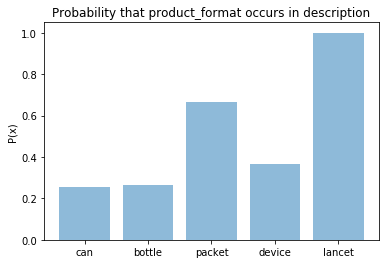

In [45]:
# 1.)
# --------------------------------------------------------------------------------------------
# Can we predict product format based on the occurance of that format name in the description?
# --------------------------------------------------------------------------------------------


# Create the Abbott product table
Abbot_products = pd.read_csv("C:/Users/corma/Documents/Python_Scripts/nlp/Abbot_products.csv", 
                             error_bad_lines=False)
Abbot_products.drop(['Unnamed: 0'], axis=1, inplace=True)


print(Abbot_products.head())

#Get diff format types
formats = set(Abbot_products['product_format'])
formats = [x for x in formats if str(x) != 'nan']
print('\nNumber of porduct_format types {}'.format(len(formats)))
print('Types: {}'.format(', '.join(formats)))
formats.remove('oz')
Abbot_products = Abbot_products[Abbot_products['product_format'] != 'oz']
print('Number of products {}'.format(len(Abbot_products)))
descriptions = Abbot_products['description']
print('*oz remove as this appears to be an incorrect labelling')


#to store freq of prod_format occuring in descr
format_is_in_descr = list()
descr_to_format_dict = {}

#loop through descirptions and get popular word frequencies in 'container' words
for i in range(0, len(Abbot_products)): 
               
    d = Abbot_products.iloc[i]['description']
    d = clean_text(d)
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(d)
    form = Abbot_products.iloc[i]['product_format']
    
    #update dictionary if the product format exists in a products description
    if form in tokens:
        descr_to_format_dict[form] = descr_to_format_dict.get(form, 0) + 1
        


value_counts = Abbot_products['product_format'].value_counts()
probs = {}
for key,val in descr_to_format_dict.items():
    pr = val/value_counts[key]
    probs[key] =  pr

plt.bar(probs.keys(), probs.values(), align='center', alpha=0.5)
plt.ylabel('P(x)')
plt.title('Probability that product_format occurs in description')
plt.show()
 

The plot shows that it is unlikely we will predict much names based on it's occurance in the description. Actually only 6 of the 18 names show up at all!

### 2.) **Popular word frequencies classification system**

We want to score an item on how close to a certain product_format it seems based on the word frequencies of its most popular words

So below we will find the 10 most popular word frequencies for each of the product formats and rank them:




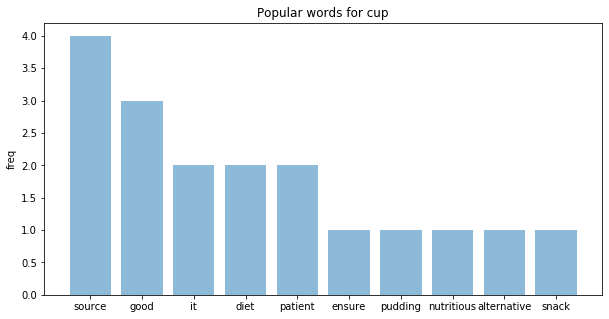

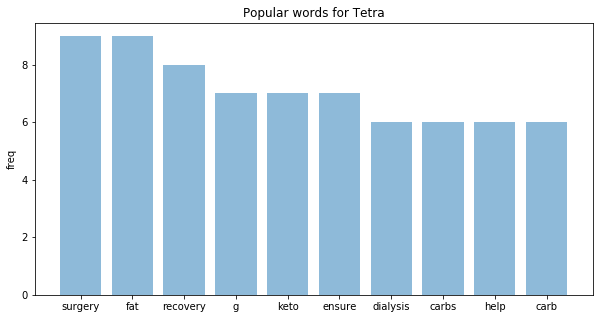

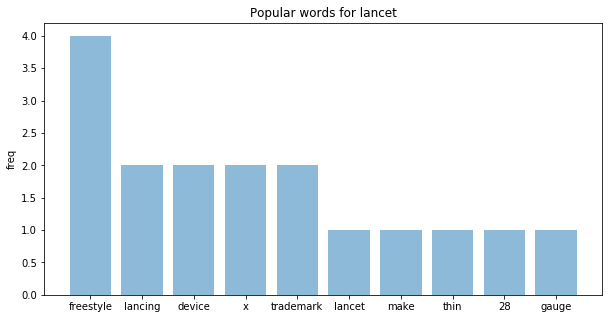

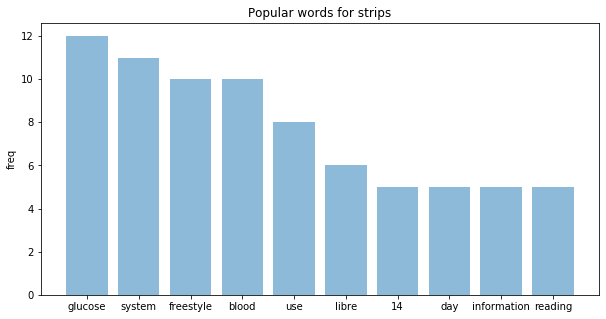

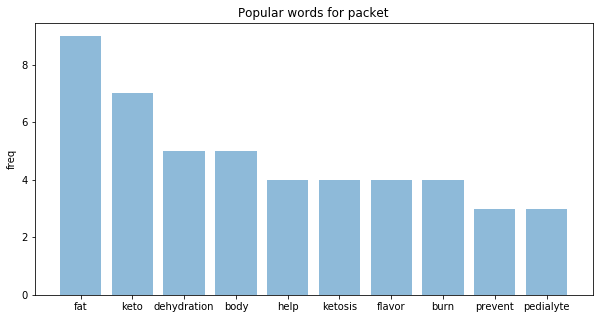

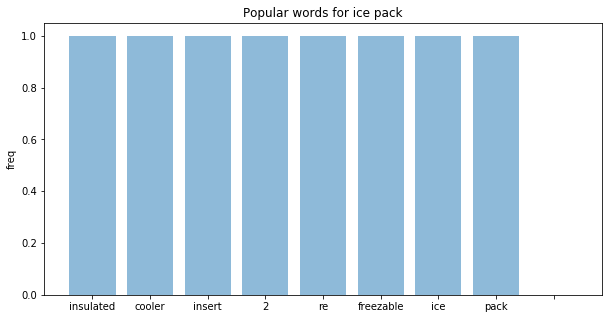

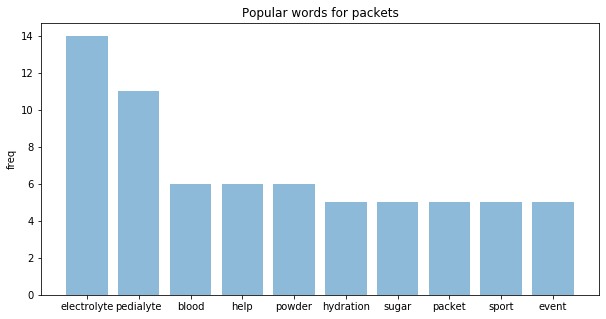

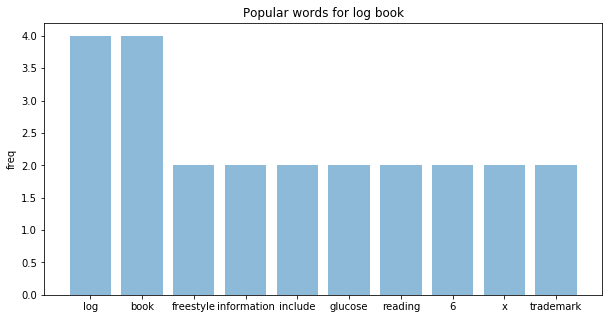

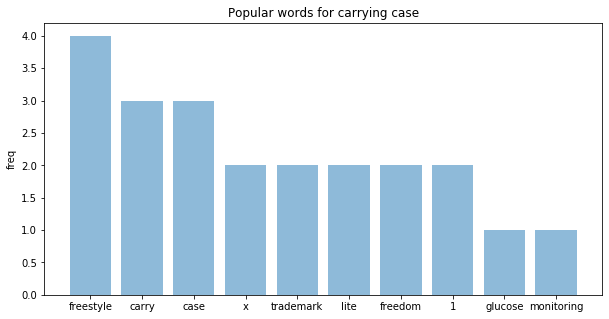

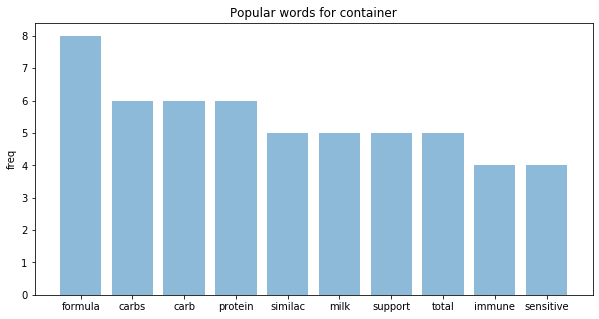

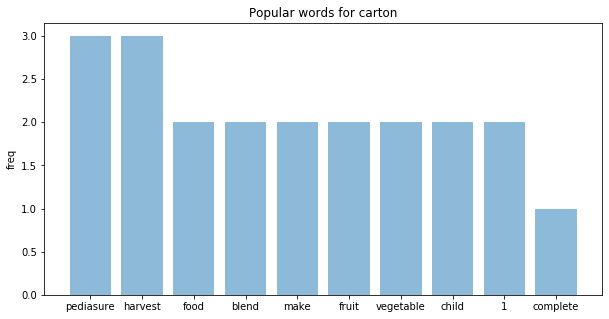

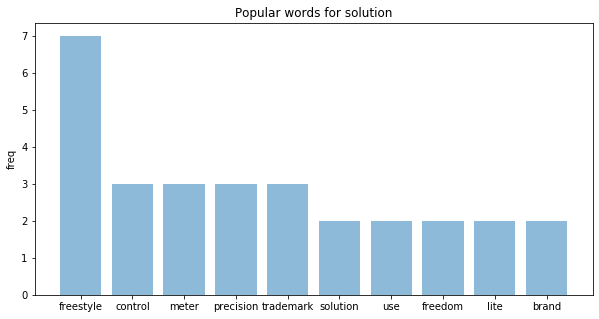

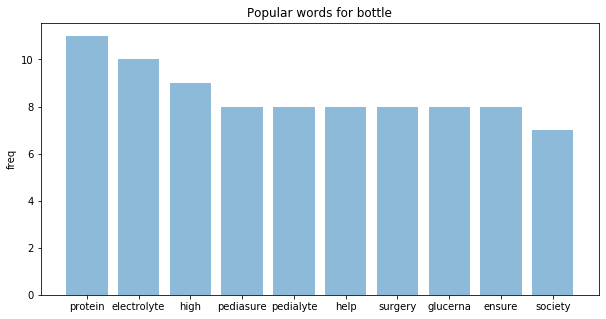

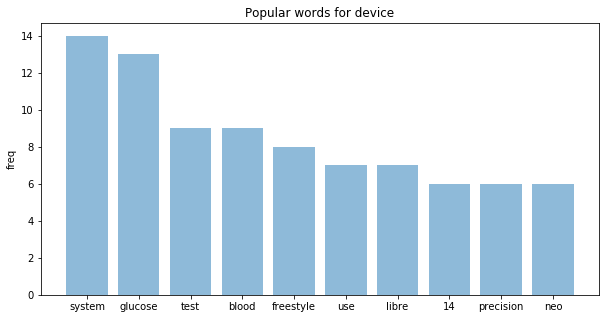

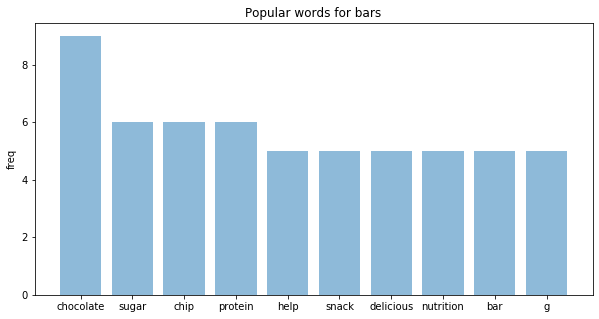

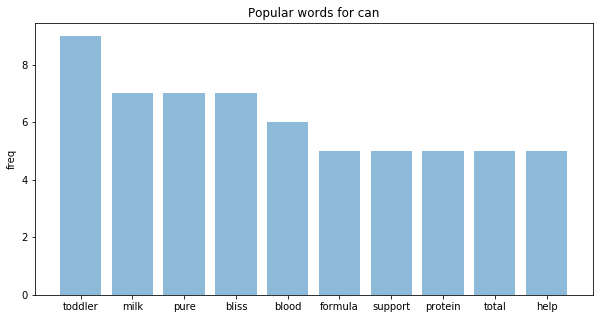

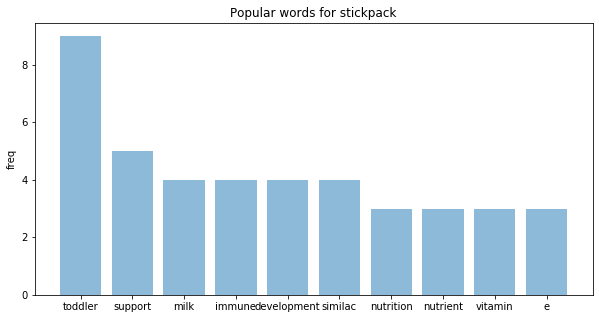

In [38]:

# 2.)
# ----------------------------------------------------------------------
# Can we use the most popular words?

#for future processing
st = pd.read_csv("C:/Users/corma/Documents/Python_Scripts/nlp/stopwords_file.csv")
stopwords = st.columns

#print out a summary of popular words for each form
word_count = 10 #arbitrary number of top words we will use
format_distributions = list()


for form in formats:
    descriptions = Abbot_products[Abbot_products['product_format'] == form] 
    descriptions = descriptions['description']
    #remove garbage characters - do this at the crawler level later
    description_top_words = {}


    #loop through descirptions and get popular word frequencies in 'container' words
    for i in range(0, len(descriptions)): 

        d = descriptions.iloc[i]
        d = clean_text(d)
        
        #tokenize and remove stopwords - trying to get rid of regular prepositions
        words = remove_stopwords(d)

        #Plot our word frequency
        fdist = nltk.FreqDist(words)
        for word in fdist.most_common(word_count):
            key = word[0]
            if key in description_top_words:      
                l = description_top_words[key]
                l.append(word[1])
                description_top_words[key] = l
            else:
                l = list()
                l.append(word[1])
                description_top_words[key] = l

              
    #Creating a tally for the amoutn of popular word we want to keep 
    max_vals = list([0]*word_count)
    names = list(['']*word_count)
    for k,v in description_top_words.items():
        if max(v) > min(max_vals):
            if k is not '':
                ind = max_vals.index(min(max_vals))
                max_vals[ind] = max(v)
                names[ind] = k

    #prepare data for plot       
    max_names_df = pd.DataFrame({'name' : names, 'count' : max_vals})
    max_names_df = max_names_df.sort_values(by=['count'], ascending=False)

    #save for later analysis
    format_distributions.append([form, max_names_df])   

    vals = max_names_df['count']
    cols = max_names_df['name']
    plt.rcParams["figure.figsize"] = [10, 5]
    plt.bar(cols, vals, align='center', alpha=0.5)
    plt.ylabel('freq')
    plt.title('Popular words for {}'.format(form))
    plt.show()

    'These plots show the freq distributions for each format and what we might expect in their descriptions'

So above we have each word frequency ordered  by it's occurance, essentially giving it a ranking out of 10
E.g. the format 'cup' has the top ranking word 'source' which occured the most frequently. We start to see early in this process that some formats just simply don't have enough words occuring at high enough a frequency. Some descriptions are just likely not long enough to have enough information for this type of analysis.

After having done this analysis, I've been reminded in my research that a TF-IDF score might be a more formal and normalized way of calculating this. Coming soon.... http://www.tfidf.com/

Next we get a product and assign it scores in each of these word frequencies (below they are set out like bins that contain the score a product gets for each group), a product does not necessarily get scores in all groups.

Then we look at the highest score and what product format it represents, and compare it to the actual product it is. We should also calculate ow many we get right to see the accuracy of this system.

In [39]:
# ----------------------------------------------------------------------------------------------------------------
'So maybe we can match up a products description to our freq distributions and have a scoring system\n'
'In ths case I will allocate points based on a word that shows up in a descriptions and it\s ranking in a products\n'
'frequency distribution - by the end of analysis, a product should have scores allocated towards some of the format names\n'
'and hopefully the highest score is associated with the product format that is actually correct for that product!'



st = pd.read_csv("C:/Users/corma/Documents/Python_Scripts/nlp/stopwords_file.csv")
stopwords = st.columns
correct_count = 0
#for collecting results
max_names_df = pd.DataFrame(columns = ['actual_product_format', 'top_words_description', 
                                       'top_words_count', 'format_group', 'format_group_score' ])

#loop through each row and 
for i in range(0, len(Abbot_products)):
    prod = Abbot_products.iloc[i]    
    desc = prod['description']
    form = prod['product_format']
    description_top_words_prod_1 = {}

    d = desc
    d = clean_text(d)

    #tokenize and remove stopwords - trying to get rid of regular prepositions
    tokenizer = RegexpTokenizer('\w+')
    tokens = tokenizer.tokenize(d)
    words = [t.lower() for t in tokens if t not in stopwords]

    #Record our word frequenct
    fdist = nltk.FreqDist(words)
    for word in fdist.most_common(10):
        key = word[0]
        if key in description_top_words_prod_1:      
            l = description_top_words_prod_1[key]
            l.append(word[1])
            description_top_words_prod_1[key] = l
        else:
            l = list()
            l.append(word[1])
            description_top_words_prod_1[key] = l

    #let's say that for each word matching a distribution, that description will get points for the ranking of that word
    #for e.g. the product 'solution' has it's top word as 'precision', therefore a description containing 'precision'
    # will get it 10 points in the 'solution' bin. We will look at everyone word in the description and tally the scores

    format_tally = {}
    for word in description_top_words_prod_1:    
        for i in range(0, len(format_distributions)):
            distr_and_name = format_distributions[i]
            distr = distr_and_name[1]
            format_name = distr_and_name[0]
            pop_words = list(distr['name'])
            if word in pop_words:                  
                ranking_val = (10 - pop_words.index(word))*description_top_words_prod_1[word][0] 

                #addpoints
                format_tally[format_name] = format_tally.get(ranking_val, 0) + ranking_val

    # Print out the popular words, the scoring in the different product format areas, 
    # and the actual product it was to compare out scoring
    
    #print(description_top_words_prod_1)
    #print(format_tally)
    #print('actual product: {}'.format(form))
    row_dict = {'actual_product_format': form, 
                         'top_words_description': description_top_words_prod_1.keys(),
                         'top_words_count': description_top_words_prod_1.values(),
                         'format_group': format_tally.keys(), 
                         'format_group_score': format_tally.values()}
    
    max_names_df.loc[len(max_names_df)] = row_dict
    isCorr = False
    if form in format_tally.keys():
        isCorr = format_tally[form] == max(format_tally.values())
        correct_count += 1
     

In [41]:

print('Total product_format precictions correct {} out of {}. {:.2f}%'.format(correct_count, len(Abbot_products), float(correct_count/len(Abbot_products))))

Total product_format precictions correct 223 out of 271. 0.82%


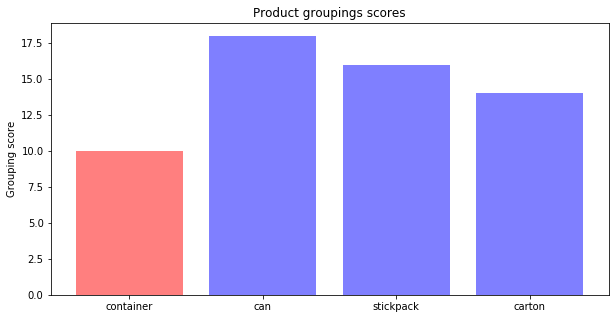

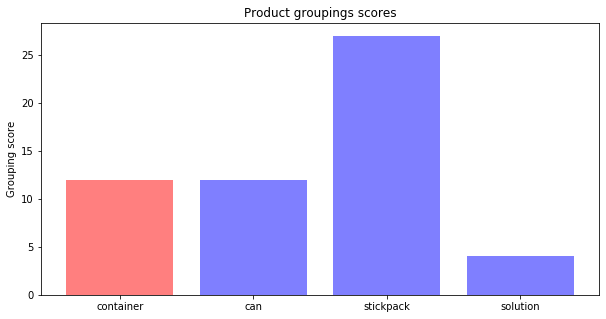

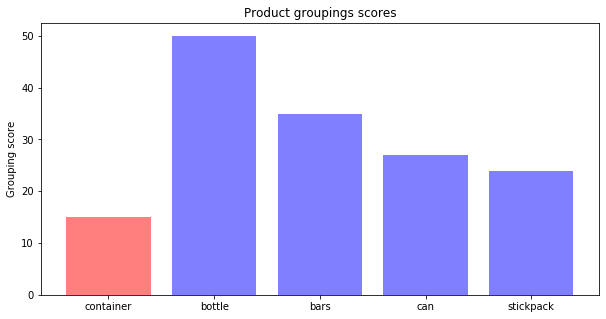

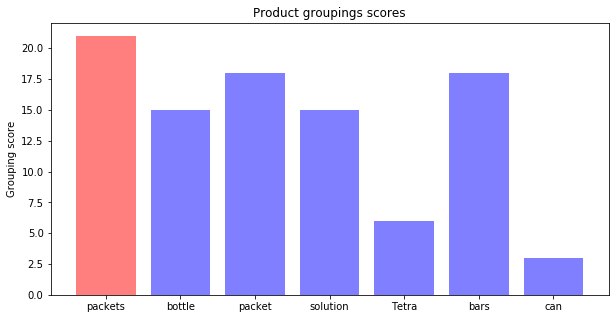

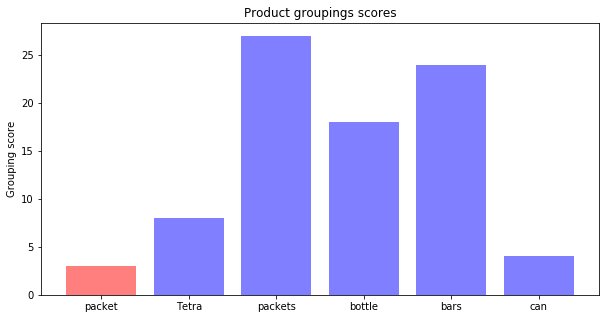

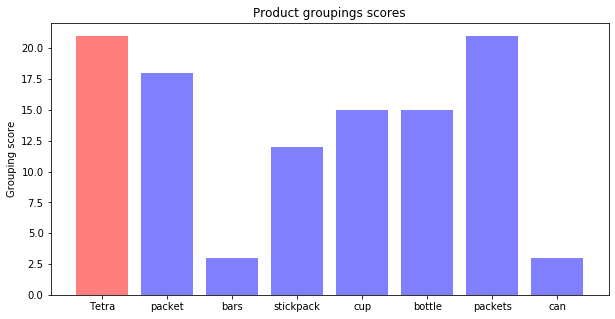

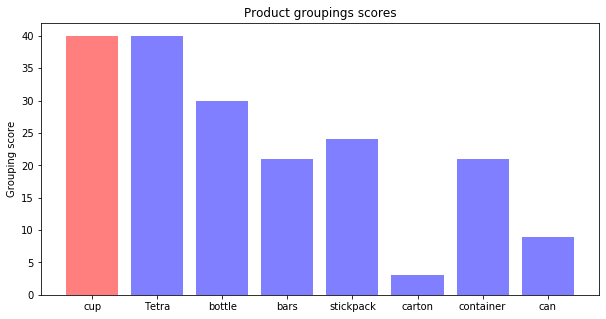

In [42]:
#select from 5 random products
a = np.arange(len(Abbot_products))
np.random.shuffle(a)
rng = a[:7]

for j in range(len(rng)):
    i = rng[j]
    row = max_names_df.loc[i]
    
    my_colors = ['b']*len(row['format_group'])
    my_colors[set(row['format_group']) == (row['actual_product_format']*3)] = 'r'
    
    #plt.rcParams["figure.figsize"] = [10, 5]
    plt.bar(row['format_group'], row['format_group_score'], align='center', alpha=0.5, color=my_colors)
    plt.ylabel('Grouping score')
    plt.title('Product groupings scores')
    plt.show()
    
    


We can see that the results can vary significantly, that the correct format is often close in score, but not always the one with the most points and around an 82% prediction rate. 

Nice, but we still woudln't be happy classifiying 18% of our products incorrectly when storing the data 
I might geuss this is result is because some of the product formats share a very similar description, so in hindsight this might effect significantly any of our analysis results

This text of course has patterns in the language that we are missing by just looking at word counts, so this might take a more sophisticated approach.


### 3.) Pattern recognition

Finally we will take the approach of basic pattern recognition using Machine Learning
Here we can hope to have classify each object as true or false for each different format type, e.g. is this product a can? is this product a container? ... etc. and hope that it has a high level of accuracy for each of them

We are using a Naive Bayes model which can be read about here:
https://www.geeksforgeeks.org/naive-bayes-classifiers/


cup score: 1.0
Tetra score: 0.8985507246376812
lancet score: 0.9927536231884058
strips score: 0.9855072463768116
packet score: 0.9782608695652174
ice pack score: 0.9927536231884058
packets score: 0.8985507246376812
log book score: 0.9855072463768116
carrying case score: 0.9782608695652174
container score: 0.9855072463768116
carton score: 0.9927536231884058
solution score: 0.9927536231884058
bottle score: 0.6159420289855072
device score: 0.9202898550724637
bars score: 0.9202898550724637
can score: 0.9057971014492754
stickpack score: 1.0


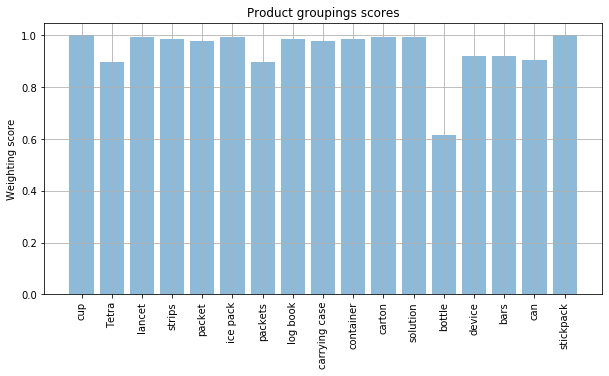

In [36]:

#https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958

# Feature vectors used for each of the words in our text, essentially a vector where each element 
# represents a word in the text and it's value has a weighting score, representing it's strength in classifying 

import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from  sklearn.metrics  import accuracy_score

scores = list()
#use ML for 1 category at a time
for prod_frm_name in formats:
    #print((prod_frm_name))
    df = pd.DataFrame({'description' : Abbot_products['description'], 
                   'is_prod' : (Abbot_products['product_format'] == prod_frm_name).astype(int)})
    #print(df['is_prod'])
    
    df_dict[prod_frm_name] = df
    arr = np.array(df[df['is_prod'] == 1])
    #print(np.count_nonzero(arr))
    l = round(len(df)/2)
    #print(len(df))

    
    X_train = df.loc[:l, 'description']
    y_train = df.loc[:l, 'is_prod']
    X_test = df.loc[l:, 'description']
    y_test = df.loc[l:, 'is_prod']


    vectorizer = TfidfVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    test_vectors = vectorizer.transform(X_test)  
    clf = MultinomialNB().fit(train_vectors, y_train)
    predicted = clf.predict(test_vectors)
    
    
    
    #print(train_vectors.shape, test_vectors.shape)  
    score = accuracy_score(y_test,predicted)
    scores.append(score)
    print('{} score: {}'.format(prod_frm_name,score))
    #print(predicted)
    
    
plt.bar(formats, scores, align='center', alpha=0.5)
plt.ylabel('Weighting score')
plt.xticks(rotation=90)
plt.title('Product groupings scores')
plt.grid()
plt.show()    

#Abbot_products[~pd.isna(Abbot_products['product_format'])]

Impressive, all but 1 format can be classified at 89% or above now. You could even be selective and only classify something if it falls above 95%, otherwise leave it blank.

Now we have some values that were blank which we know the values for, so let's test train the classifier on all our previous data and then see how it goes on our 'unknown' formats

Coming soon.....

In [46]:
#construct = ab_lookup  #Just to get this out of the analysis page
# Create a dataframe from constructed table above
#lookup = pd.DataFrame(data=construct)
# Create an array from lookup table to help filter later on
#lookup_filter = lookup["item_type"].array
#lookup.drop(["name"], axis=1, inplace=True)
#lookup = lookup.set_index("item_type")

#Abbot_products_2 = pd.concat([Abbot_products, lookup], sort=True)
#print(len(Abbot_products_2[~pd.isna(Abbot_products_2['product_format'])]))
